In [4]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'

os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()



Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

In [5]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-09-03 19:58:54--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.65MB/s    in 0.2s    

2022-09-03 19:58:54 (4.65 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [6]:
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.appName("kitchen_ETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [8]:
# Import Amazon Data
from pyspark import SparkFiles
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Kitchen_v1_00.tsv.gz'
spark.sparkContext.addFile(url)

In [9]:
kitchen_df = spark.read.csv(SparkFiles.get('amazon_reviews_us_Kitchen_v1_00.tsv.gz'), sep='\t', header=True)
kitchen_df = kitchen_df.dropDuplicates(['review_id'])

In [10]:
kitchen_df.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   37000337|R3DT59XH7HXR9K|B00303FI0G|     529320574|Arthur Court Pape...|         Kitchen|          5|            0|          0|   N|                Y|Beautiful. Looks ...|Beautiful.  Looks...| 2015-08-31|
|         US|   15272914|R1LFS11BNASSU8|B00JCZKZN6|     274237558|Olde Thompson Bav...|         Kitchen|          5|    

In [11]:
# Count the number of records (rows) in the dataset.
kitchen_df.count()

4880466

### Function to set nullable states to match schema

In [12]:
import pyspark.sql.functions as F

# https://stackoverflow.com/questions/46072411/can-i-change-the-nullability-of-a-column-in-my-spark-dataframe



def set_df_columns_nullable(spark, df, column_list, nullable=True):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

In [13]:
# Transform the dataset to fit the tables in the schema file. Be sure the DataFrames match in data type and in column name.

# Schema: 
# CREATE TABLE review_id_table (
#   review_id TEXT PRIMARY KEY NOT NULL,
#   customer_id INTEGER,
#   product_id TEXT,
#   product_parent INTEGER,
#   review_date DATE -- this should be in the formate yyyy-mm-dd
# );



In [14]:
# Check datatypes
kitchen_df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [15]:
# Convert columns in root dataframe to schema datatype
from pyspark.sql.types import IntegerType,DateType
kitchen_df = kitchen_df.withColumn('customer_id', kitchen_df.customer_id.cast(IntegerType()))
kitchen_df = kitchen_df.withColumn('product_parent', kitchen_df.product_parent.cast(IntegerType()))
kitchen_df = kitchen_df.withColumn('review_date', kitchen_df.review_date.cast(DateType()))

# vine
kitchen_df = kitchen_df.withColumn('star_rating', kitchen_df.star_rating.cast(IntegerType()))
kitchen_df = kitchen_df.withColumn('helpful_votes', kitchen_df.helpful_votes.cast(IntegerType()))
kitchen_df = kitchen_df.withColumn('total_votes', kitchen_df.total_votes.cast(IntegerType()))

In [16]:
kitchen_df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



### review_id_table table

In [17]:
kitchen_review_id_df = kitchen_df.select(['review_id','customer_id','product_id','product_parent','review_date']).dropna()
kitchen_review_id_df.show(2)

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
|R3DT59XH7HXR9K|   37000337|B00303FI0G|     529320574| 2015-08-31|
|R1LFS11BNASSU8|   15272914|B00JCZKZN6|     274237558| 2015-08-31|
+--------------+-----------+----------+--------------+-----------+
only showing top 2 rows



In [18]:
# fix nullability
kitchen_review_id_df = set_df_columns_nullable(spark, kitchen_review_id_df, ['review_id'], False)

kitchen_review_id_df.printSchema()

root
 |-- review_id: string (nullable = false)
 |-- customer_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- review_date: date (nullable = true)



### products table

In [19]:
kitchen_products_df = kitchen_df.select(['product_id','product_title']).dropna()
kitchen_products_df.show(2)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B00303FI0G|Arthur Court Pape...|
|B00JCZKZN6|Olde Thompson Bav...|
+----------+--------------------+
only showing top 2 rows



In [20]:
# fix nullability
kitchen_products_df = set_df_columns_nullable(spark, kitchen_products_df, ['product_id'], False)

kitchen_products_df.printSchema()

root
 |-- product_id: string (nullable = false)
 |-- product_title: string (nullable = true)



### customers table

In [21]:
kitchen_customers_df = kitchen_df.select(['customer_id'])

In [22]:
kitchen_customers_df = kitchen_customers_df.groupBy('customer_id').count()
kitchen_customers_df.show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
|   23042837|    1|
|   48875707|    2|
|   48088660|    1|
|   20781887|    6|
|    1075003|    1|
|   28377689|    3|
|    8338749|    1|
|   39271457|    6|
|   38209321|    5|
|   51397605|    1|
|   45337932|    7|
|   12948675|    3|
|   38892468|    1|
|   43582450|    1|
|   13156755|    1|
|   13433330|    1|
|   17067926|    7|
|   13780617|    1|
|   50607818|    1|
|   33437759|    2|
+-----------+-----+
only showing top 20 rows



In [23]:
kitchen_customers_df = kitchen_customers_df.withColumnRenamed('count','customer_count')
kitchen_customers_df.show()

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   23042837|             1|
|   48875707|             2|
|   48088660|             1|
|   20781887|             6|
|    1075003|             1|
|   28377689|             3|
|    8338749|             1|
|   39271457|             6|
|   38209321|             5|
|   51397605|             1|
|   45337932|             7|
|   12948675|             3|
|   38892468|             1|
|   43582450|             1|
|   13156755|             1|
|   13433330|             1|
|   17067926|             7|
|   13780617|             1|
|   50607818|             1|
|   33437759|             2|
+-----------+--------------+
only showing top 20 rows



In [24]:
# fix nullability
kitchen_customers_df = set_df_columns_nullable(spark, kitchen_customers_df, ['customer_id'], False)
kitchen_customers_df = set_df_columns_nullable(spark, kitchen_customers_df, ['customer_count'])

kitchen_customers_df.printSchema()

root
 |-- customer_id: integer (nullable = false)
 |-- customer_count: long (nullable = true)



### vine table

In [25]:
kitchen_vine_df = kitchen_df.select(['review_id','star_rating','helpful_votes','total_votes','vine'])
kitchen_vine_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
|R3DT59XH7HXR9K|          5|            0|          0|   N|
|R1LFS11BNASSU8|          5|            0|          1|   N|
|R296RT05AG0AF6|          5|            0|          0|   N|
|R3V37XDZ7ZCI3L|          5|            0|          1|   N|
|R14GU232NQFYX2|          5|            0|          0|   N|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [26]:
# fix nullability
kitchen_vine_df = set_df_columns_nullable(spark, kitchen_vine_df, ['review_id'], False)

kitchen_vine_df.printSchema()

root
 |-- review_id: string (nullable = false)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)



In [27]:
# Load the DataFrames that correspond to tables into an RDS instance. 
# Note: This process can take up to 10 minutes for each. Be sure that everything is correct before uploading.
# from config import aws_url, aws_pw


# aws_url = 'http'
# aws_pw = 'pw'

# mode = "append"
# jdbc_url=f"jdbc:postgresql://{aws_url}:5432/postgres"
# config = {"user":"postgres", 
#           "password": aws_pw, 
#           "driver":"org.postgresql.Driver"}

In [28]:
# df_list =    [kitchen_review_id_df, kitchen_products_df, kitchen_customers_df, kitchen_vine_df]
# rds_tables = ['review_id_table',    'products',           'customers',         'vine_table']

# for i in range(len(df_list)):
#   df_list[i].write.jdbc(url=jdbc_url, table=rds_tables[i], mode=mode, properties=config)

# Level-2

In [29]:
vine_yes_df = kitchen_vine_df.filter(kitchen_vine_df['vine'] == 'Y')
vine_yes_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
|R2ULP8AXSSKW1B|          4|            0|          0|   Y|
| RWQ9437QNHAEK|          3|            0|          0|   Y|
|R1EYKPBEMZS8RQ|          3|            0|          0|   Y|
|R1Z5WEY1AZVTC3|          3|            6|          6|   Y|
|R1CMN2BQH5IS6H|          5|            0|          1|   Y|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [30]:
vine_no_df = kitchen_vine_df.filter(kitchen_vine_df['vine'] == 'N')
vine_no_df.show(5)

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
|R3DT59XH7HXR9K|          5|            0|          0|   N|
|R1LFS11BNASSU8|          5|            0|          1|   N|
|R296RT05AG0AF6|          5|            0|          0|   N|
|R3V37XDZ7ZCI3L|          5|            0|          1|   N|
|R14GU232NQFYX2|          5|            0|          0|   N|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows



In [31]:
print(f'Vine yes count: {vine_yes_df.count()}')
print(f'Vine no count:  {vine_no_df.count()}')

Vine yes count: 24434
Vine no count:  4856026


In [32]:
sample_ratio = 24434 / 4856026
sample_ratio

0.005031686403655994

In [33]:
# sample larger set down to minimize class imbalance
vine_no_sample_df = vine_no_df.sample(sample_ratio)
vine_no_sample_df.count()

24422

In [34]:
pd_vine_yes = vine_yes_df.toPandas()
pd_vine_yes= pd_vine_yes.set_index('review_id')
pd_vine_yes.head()

,star_rating,helpful_votes,total_votes,vine
review_id,,,,
R2ULP8AXSSKW1B,4,0,0,Y
RWQ9437QNHAEK,3,0,0,Y
R1EYKPBEMZS8RQ,3,0,0,Y
R1Z5WEY1AZVTC3,3,6,6,Y
R1CMN2BQH5IS6H,5,0,1,Y


In [35]:
pd_vine_no = vine_no_sample_df.toPandas()
pd_vine_no = pd_vine_no.set_index('review_id')
pd_vine_no.head()

,star_rating,helpful_votes,total_votes,vine
review_id,,,,
R1V3CPNABFICB6,3,0,0,N
R2DDNYQSG9PH4D,5,0,0,N
R2SS1DW53GU1XQ,5,0,0,N
RTXQ2R3XDOUG1,5,0,0,N
RGK54OOQBQNJR,5,0,0,N


In [36]:
pd_vine_yes.describe()

,star_rating,helpful_votes,total_votes
count,24434.000000,24434.000000,24434.000000
mean,4.248915,5.964558,6.917492
std,0.897344,44.845975,47.167036
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000
50%,4.000000,1.000000,1.000000
75%,5.000000,2.000000,3.000000
max,5.000000,3325.000000,3428.000000


In [37]:
pd_vine_no.describe()

,star_rating,helpful_votes,total_votes
count,24422.000000,24422.000000,24422.000000
mean,4.215011,2.172590,2.580419
std,1.280905,22.258084,22.941145
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,1.000000
max,5.000000,2516.000000,2537.000000


The Kitchen reviews dataset, in contrast to the Home Improvement dataset, shows a rather large difference between the number of helpful votes and the number of total votes, with no large difference on star rating.

The difference in reviews between these two datasets may indicate that there are different patterns to the ways in which buyers of kitchen goods and buyers of home improvement goods interact and interpret reviews.  It may also indicate that there is some difference in the way Vine is implemented.  It is worth noting here that although there isn't a huge difference between the standard error of star ratings on vine reviews and non-vine reviews, it *is* a detectably smaller range of scores when Vine is present.

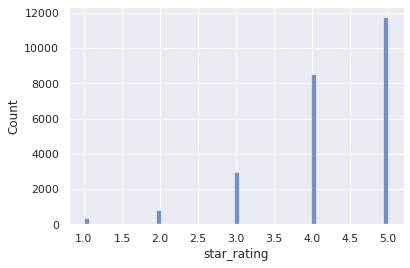

In [38]:
# libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
# df = sns.load_dataset("iris")
sns

sns.histplot(data=pd_vine_yes, x="star_rating")
plt.show()

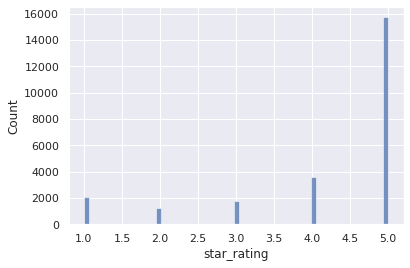

In [39]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
# df = sns.load_dataset("iris")
sns

sns.histplot(data=pd_vine_no, x="star_rating")
plt.show()

Although vine reviews seem to rarely have a rating under 3 stars, they do seem to have more 3- and 4-star reviews than their non-Vine counterparts.

In [40]:
import pandas as pd
vine_yes_no = pd.concat([pd_vine_yes, pd_vine_no])
vine_yes_no.head()

,star_rating,helpful_votes,total_votes,vine
review_id,,,,
R2ULP8AXSSKW1B,4,0,0,Y
RWQ9437QNHAEK,3,0,0,Y
R1EYKPBEMZS8RQ,3,0,0,Y
R1Z5WEY1AZVTC3,3,6,6,Y
R1CMN2BQH5IS6H,5,0,1,Y


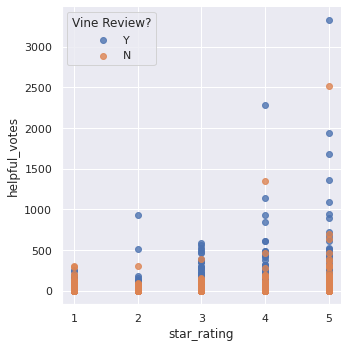

In [41]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="star_rating", y="helpful_votes", data=vine_yes_no, fit_reg=False, hue='vine', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper left', title='Vine Review?')

plt.show()

Here, it is evident that Vine reviews tend to receive more 'helpful votes' than non-vine reviews.

In [42]:
review_date_df = kitchen_df.select(['review_id','review_date']).toPandas()
review_date_df.head()

,review_id,review_date
0,R3DT59XH7HXR9K,2015-08-31
1,R1LFS11BNASSU8,2015-08-31
2,R296RT05AG0AF6,2015-08-31
3,R3V37XDZ7ZCI3L,2015-08-31
4,R14GU232NQFYX2,2015-08-31


In [43]:
vine_date_df = pd.merge(vine_yes_no, review_date_df, on='review_id', how='left')
vine_date_df.head()

,review_id,star_rating,helpful_votes,total_votes,vine,review_date
0,R2ULP8AXSSKW1B,4,0,0,Y,2015-08-31
1,RWQ9437QNHAEK,3,0,0,Y,2015-08-31
2,R1EYKPBEMZS8RQ,3,0,0,Y,2015-08-31
3,R1Z5WEY1AZVTC3,3,6,6,Y,2015-08-31
4,R1CMN2BQH5IS6H,5,0,1,Y,2015-08-31
